Vehicle Detection.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf

import utils
import detection

from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

In [2]:
#data handling:

vehicle_files_dir = './data/vehicles/'
non_vehicle_files_dir = './data/non-vehicles/'

vehicle_files = utils.extract_files(vehicle_files_dir)
vehicle_images = [mpimg.imread(file) for file in vehicle_files]

non_vehicle_files = utils.extract_files(non_vehicle_files_dir)
non_vehicle_images = [mpimg.imread(file) for file in non_vehicle_files] 

print('Number of vehicle files: {}'.format(len(vehicle_files)))
print('Number of non-vehicle files: {}'.format(len(non_vehicle_files)))

Number of vehicle files: 8792
Number of non-vehicle files: 8968


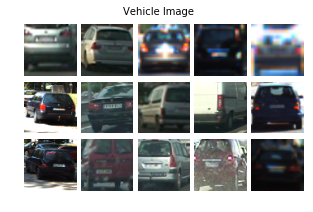

In [3]:
utils.show_images(vehicle_files, num_of_images=15, main_title='Vehicle Image')


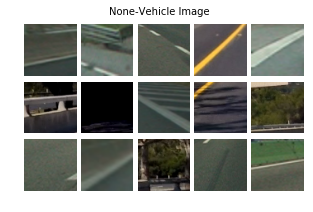

In [4]:
utils.show_images(non_vehicle_files, num_of_images=15, main_title='None-Vehicle Image')

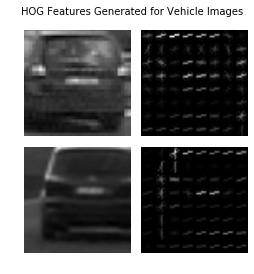

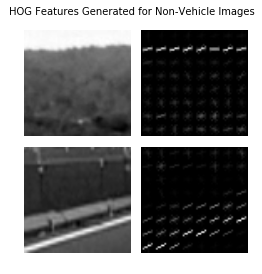

In [5]:
vehicles = []
vehicles_hog_features = []

for i in range(2):
    rnd_idx = np.random.randint(1, len(vehicle_files))
    image = mpimg.imread(vehicle_files[rnd_idx])
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2

    features, hog_image = utils.get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
    vehicles.append(hog_image)
    vehicles_hog_features.append(gray)

utils.display_hog_features(vehicles, vehicles_hog_features, 
                              color_map='gray', 
                              suptitle='HOG Features Generated for Vehicle Images')

non_vehicles = []
non_vehicles_hog_features = []

for i in range(2):
    rnd_idx = np.random.randint(1, len(non_vehicle_files))
    image = mpimg.imread(non_vehicle_files[rnd_idx])
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2

    features, hog_image = utils.get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
    non_vehicles.append(hog_image)
    non_vehicles_hog_features.append(gray)

utils.display_hog_features(non_vehicles, non_vehicles_hog_features, 
                              color_map='gray', 
                              suptitle='HOG Features Generated for Non-Vehicle Images')

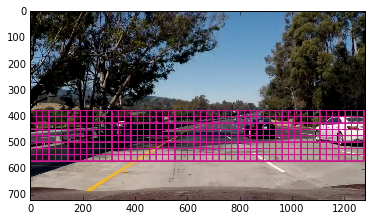

In [6]:
img_path = './test_images/test5.jpg'
image = mpimg.imread(img_path)
copy_image = np.copy(image)

windows = detection.slide_window(copy_image, xy_window=(96, 96), xy_overlap=(0.75, 0.75),
                                                                 y_start_stop=[380, 580])

img = utils.draw_sliding_windows(image, windows)
plt.imshow(img)
plt.show()

In [7]:
color_space = 'YCrCb'  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8  # HOG pixels per cell
cell_per_block = 2  # HOG cells per block
hog_channel = 'ALL'  # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32)  # Spatial binning dimensions
hist_bins = 32  # Number of histogram bins
spatial_feat = True  # Spatial features on or off
hist_feat = True  # Histogram features on or off
hog_feat = True  # HOG features on or off

C_values = [0.08, 0.2, 0.4, 0.8, 1.0, 1.2, 1.4, 1.8, 2.6]
penalties = ['l2']
losses = ['hinge', 'squared_hinge']

training_accuracies = []
validation_accuracies = []
best_c = 1.0
best_penalty = 'l2'
best_loss = 'hinge'

best_accuracy = 0.0

vehicle_features = detection.extract_features(vehicle_images, color_space, orient, spatial_size, hist_bins,
                                                                pix_per_cell, cell_per_block,
                                              spatial_feat, hist_feat, hog_feat,hog_channel)
print('Shape of the vehicle features: {}'.format(vehicle_features.shape))

non_vehicle_features = detection.extract_features(non_vehicle_images, color_space, orient, spatial_size,
                                                        hist_bins, pix_per_cell, cell_per_block,
                                                  spatial_feat, hist_feat, hog_feat, hog_channel)

X_features = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64)
print('Shape of the entire dataset: {}'.format(features.shape))

y_features = np.hstack((np.ones(len(vehicle_images)), np.zeros(len(non_vehicle_images))))

      

for c in C_values:
    for penalty in penalties:
        for loss in losses:
            X_train, X_test, y_train, y_test = train_test_split(X_features, y_features,
                                                        test_size=0.3, random_state=2048)
            
            scaler = StandardScaler().fit(X_train)
      
            X_train = scaler.transform(X_train)            
            X_test = scaler.transform(X_test)
            
            svc = LinearSVC(C = c, penalty = penalty, loss = loss).fit(X_train, y_train)
            accuracy = svc.score(X_test, y_test)
            print('Validation accuracy: {:.4f} with C: {}, panelty: {}, loss: {}'.format(
                    accuracy, c, penalty, loss))
            
            if best_accuracy < accuracy:
                best_accuracy = accuracy                
                best_c = c
                best_loss = loss
                best_penalty = penalty
            
            validation_accuracies.append(accuracy)
            training_accuracies.append(svc.score(X_train, y_train))

print('Best validation accuracy: {:.4f}'.format(best_accuracy))
print('Best parameters: C: {}, penalty: {}, loss: {}'.format(best_c, best_penalty, best_loss))

print('')
print('Retaining with best hyper-parameters')

scaler = StandardScaler().fit(X_features)
X_features = scaler.transform(X_features)
svc = LinearSVC(C = best_c, penalty = best_penalty, loss = best_loss).fit(X_features, y_features)

Shape of the vehicle features: (8792, 8460)
Shape of the entire dataset: (1764,)
Validation accuracy: 0.9908 with C: 0.08, panelty: l2, loss: hinge
Validation accuracy: 0.9908 with C: 0.08, panelty: l2, loss: squared_hinge
Validation accuracy: 0.9908 with C: 0.2, panelty: l2, loss: hinge
Validation accuracy: 0.9908 with C: 0.2, panelty: l2, loss: squared_hinge
Validation accuracy: 0.9908 with C: 0.4, panelty: l2, loss: hinge
Validation accuracy: 0.9908 with C: 0.4, panelty: l2, loss: squared_hinge
Validation accuracy: 0.9908 with C: 0.8, panelty: l2, loss: hinge
Validation accuracy: 0.9908 with C: 0.8, panelty: l2, loss: squared_hinge
Validation accuracy: 0.9908 with C: 1.0, panelty: l2, loss: hinge
Validation accuracy: 0.9908 with C: 1.0, panelty: l2, loss: squared_hinge
Validation accuracy: 0.9908 with C: 1.2, panelty: l2, loss: hinge
Validation accuracy: 0.9908 with C: 1.2, panelty: l2, loss: squared_hinge
Validation accuracy: 0.9908 with C: 1.4, panelty: l2, loss: hinge
Validation 

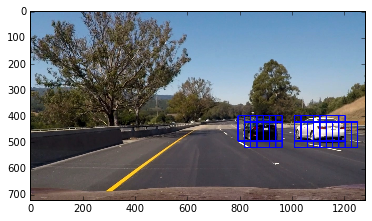

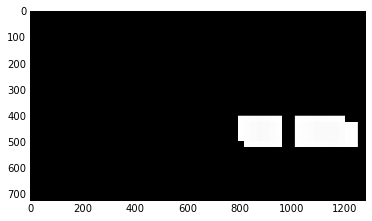

In [8]:
img_path = './test_images/test6.jpg'
image = mpimg.imread(img_path)
copy_image = np.copy(image)
draw_image = np.copy(image)
image = image.astype(np.float32)/255.0

y_start_stop = [400,600]  # Min and max in y to search in sliding windows

windows = detection.slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop,
                                xy_window=(96, 96), xy_overlap=(0.75, 0.75))

hot_windows = detection.search_windows(image, windows, svc, scaler, color_space=color_space,
                             spatial_size=spatial_size, hist_bins=hist_bins,
                             orient=orient, pix_per_cell=pix_per_cell,
                             cell_per_block=cell_per_block,
                             hog_channel=hog_channel, spatial_feat=spatial_feat,
                             hist_feat=hist_feat, hog_feat=hog_feat)

window_img = detection.draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=3)

plt.imshow(window_img)
plt.show()

heat_map = np.zeros_like(image)
heat_map = utils.add_heat(heat_map, hot_windows)

plt.imshow(heat_map, cmap='hot')



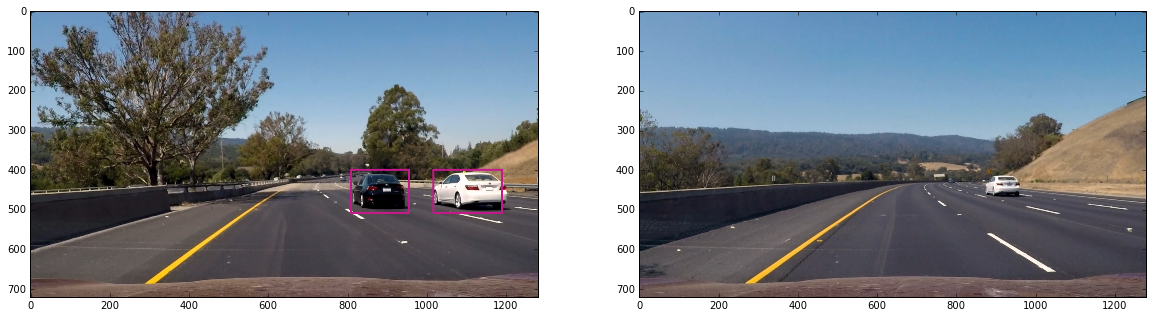

In [9]:
x_start_stop=[None, None]
y_start_stop = [400,600] 
xy_window=(96, 86)
xy_overlap=(0.72, 0.72)
vehicle_detector = detection.VehicleDetect(color_space=color_space,
                                  orient=orient,
                                  pix_per_cell=pix_per_cell,
                                  cell_per_block=cell_per_block,
                                  hog_channel=hog_channel,
                                  spatial_size=spatial_size,
                                  hist_bins=hist_bins,
                                  spatial_feat=spatial_feat,
                                  hist_feat=hist_feat,
                                  hog_feat=hog_feat,
                                  y_start_stop=y_start_stop,
                                  x_start_stop=x_start_stop,
                                  xy_window=xy_window,
                                  xy_overlap=xy_overlap,
                                  heat_threshold = 1,
                                  scaler=scaler,
                                  classifier=svc) 

test_image_path_1 = './test_images/test6.jpg'
test_image_1 = mpimg.imread(test_image_path_1)
output_1 = vehicle_detector.detect(test_image_1)


vehicle_detector = detection.VehicleDetect(color_space=color_space,
                                  orient=orient,
                                  pix_per_cell=pix_per_cell,
                                  cell_per_block=cell_per_block,
                                  hog_channel=hog_channel,
                                  spatial_size=spatial_size,
                                  hist_bins=hist_bins,
                                  spatial_feat=spatial_feat,
                                  hist_feat=hist_feat,
                                  hog_feat=hog_feat,
                                  y_start_stop=y_start_stop,
                                  x_start_stop=x_start_stop,
                                  xy_window=xy_window,
                                  xy_overlap=xy_overlap,
                                  heat_threshold = 1,
                                  scaler=scaler,
                                  classifier=svc) 
test_image_path_2 = './test_images/test3.jpg'
test_image_2 = mpimg.imread(test_image_path_2)
output_2 = vehicle_detector.detect(test_image_2)

plt.figure(figsize=(20, 16))

plt.subplot(1, 2, 1)
plt.imshow(output_1)

plt.subplot(1, 2, 2)
plt.imshow(output_2)

plt.show()

In [10]:
x_start_stop=[None, None]
y_start_stop = [400,600] 
xy_window=(96, 86)
xy_overlap=(0.75, 0.75)
vehicle_detector = detection.VehicleDetect(color_space=color_space,
                                  orient=orient,
                                  pix_per_cell=pix_per_cell,
                                  cell_per_block=cell_per_block,
                                  hog_channel=hog_channel,
                                  spatial_size=spatial_size,
                                  hist_bins=hist_bins,
                                  spatial_feat=spatial_feat,
                                  hist_feat=hist_feat,
                                  hog_feat=hog_feat,
                                  y_start_stop=y_start_stop,
                                  x_start_stop=x_start_stop,
                                  xy_window=xy_window,
                                  xy_overlap=xy_overlap,
                                  heat_threshold = 1,
                                  scaler=scaler,
                                  classifier=svc) 


output_file = './processed_project_video.mp4'
input_file = './project_video.mp4'


clip = VideoFileClip(input_file)
out_clip = clip.fl_image(vehicle_detector.detect) 
out_clip.write_videofile(output_file, audio=False)

[MoviePy] >>>> Building video ./processed_project_video.mp4
[MoviePy] Writing video ./processed_project_video.mp4


100%|█████████▉| 1260/1261 [25:58<00:01,  1.25s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./processed_project_video.mp4 

